In [1]:
import os
import vector
import mplhep
import numpy as np
import awkward as ak
import boost_histogram as bh
import matplotlib.pyplot as plt

In [2]:
# CERNBox link: https://cernbox.cern.ch/s/jcg2o409jjoARcJ
#data_dir = '/eos/user/l/ltani/ML-tau-data/'
#zh_path = os.path.join(data_dir, 'zh.parquet')
#z_path = os.path.join(data_dir, 'z.parquet')
#qq_path = os.path.join(data_dir, 'qq.parquet')

In [3]:
data_dir_temporary = '/scratch/persistent/joosep/ml-tau/20240520_qq_zh_2m_merged/'
zh_path = os.path.join(data_dir_temporary, 'zh_train.parquet')
z_path = os.path.join(data_dir_temporary, 'z_train.parquet')
qq_path = os.path.join(data_dir_temporary, 'qq_train.parquet')

In [4]:
data = ak.from_parquet(data_dir_temporary)
data

<Array [??, ??, ??, ??, ..., ??, ??, ??, ??] type='6114493 * union[{reco_ca...'>

In [5]:
zh_data = ak.from_parquet(zh_path)
z_data = ak.from_parquet(z_path)
qq_data = ak.from_parquet(qq_path)

In [6]:
# Print number of jets in the datasets
print(f"[ZH (H->tautau)] \t Num jets: {len(zh_data)}")
print(f"[Z  (Z->tautau)] \t Num jets: {len(z_data)}")
print(f"[qq] \t\t\t Num jets: {len(qq_data)}")

[ZH (H->tautau)] 	 Num jets: 1706814
[Z  (Z->tautau)] 	 Num jets: 366037
[qq] 			 Num jets: 2818742


In [7]:
# Access properties associated for each jet. Same for each dataset
zh_data.fields

['reco_cand_p4s',
 'reco_cand_charge',
 'reco_cand_pdg',
 'reco_jet_p4s',
 'reco_cand_dz',
 'reco_cand_d3',
 'reco_cand_dz_err',
 'reco_cand_d3_err',
 'reco_cand_d0',
 'reco_cand_z0',
 'reco_cand_d0_err',
 'reco_cand_z0_err',
 'gen_jet_p4s',
 'gen_jet_tau_decaymode',
 'gen_jet_tau_p4s',
 'gen_jet_full_tau_p4s']

## Description of variables

|  Name |  Description |
|---|---|
| reco_cand_p4s | 4-momenta per reco cand in the reco jet. |
| reco_cand_charge | Charge per cand in the jet.|
| reco_cand_pdg | PDGid per cand in the jet.|
| reco_jet_p4s | RecoJet 4-momenta. |
| reco_cand_dz | Longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dz_err | Uncertainty of the longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy | Transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy_err | Uncertainty of the transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| gen_jet_p4s | GenJet 4-momenta. Matched with RecoJet within a cone of radius dR < 0.4.|
| gen_jet_tau_decaymode | Decay mode of the associated genTau. Jets that have associated leptonically decaying taus are removed, so there are no DM=16 jets. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_tau_p4s | Visible 4-momenta of the genTau. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_full_tau_p4s | Full 4-momenta (with neutrino) of the genTau matched to the genJet and recoJet. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. (For debugging purposes)|

In [8]:
# Create 4-vectors from the information in the .parquet file data and access information such as energy or pT:

def to_p4(p4_obj):
    return vector.awk(
        ak.zip(
            {
                "mass": p4_obj.tau,
                "x": p4_obj.x,
                "y": p4_obj.y,
                "z": p4_obj.z,
            }
        )
    )

def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

gen_tau_p4s = to_p4(zh_data.gen_jet_tau_p4s)
gen_tau_pt = gen_tau_p4s.pt


Text(0, 0.5, 'Number of reco jets / bin')

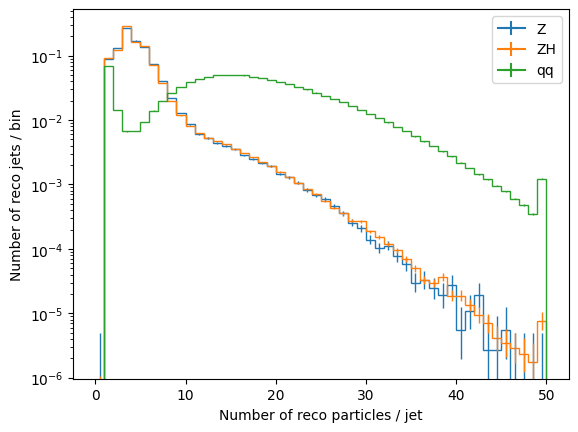

In [9]:
# Get number of particles per jet:
bins = np.linspace(0,50,51)
mplhep.histplot(to_bh(ak.num(z_data["reco_cand_p4s"]), bins=bins), histtype="step", lw=1, flow="sum", label="Z", density=True)
mplhep.histplot(to_bh(ak.num(zh_data["reco_cand_p4s"]), bins=bins), histtype="step", lw=1, flow="sum", label="ZH", density=True)
mplhep.histplot(to_bh(ak.num(qq_data["reco_cand_p4s"]), bins=bins), histtype="step", lw=1, flow="sum", label="qq", density=True)
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("Number of reco particles / jet")
plt.ylabel("Number of reco jets / bin")

Text(0, 0.5, 'Number of gen jets / bin')

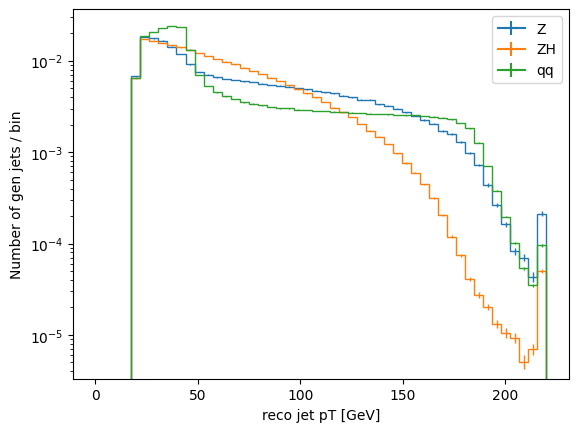

In [10]:
bins = np.linspace(0,220,51)
mplhep.histplot(to_bh(to_p4(z_data["reco_jet_p4s"]).pt, bins=bins), histtype="step", lw=1, flow="sum", label="Z", density=True)
mplhep.histplot(to_bh(to_p4(zh_data["reco_jet_p4s"]).pt, bins=bins), histtype="step", lw=1, flow="sum", label="ZH", density=True)
mplhep.histplot(to_bh(to_p4(qq_data["reco_jet_p4s"]).pt, bins=bins), histtype="step", lw=1, flow="sum", label="qq", density=True)
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("reco jet pT [GeV]")
plt.ylabel("Number of gen jets / bin")

Text(0, 0.5, 'matched jets / bin')

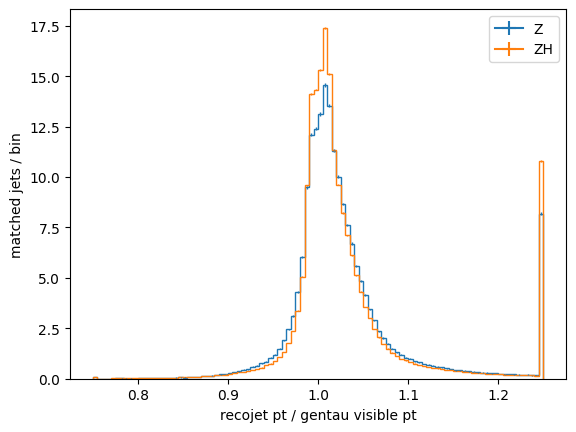

In [11]:
bins = np.linspace(0.75,1.25,101)

mplhep.histplot(
    to_bh(
        to_p4(z_data["reco_jet_p4s"]).pt / to_p4(z_data["gen_jet_tau_p4s"]).pt
    , bins=bins), histtype="step", lw=1, flow="sum", label="Z", density=True)

mplhep.histplot(
    to_bh(
        to_p4(zh_data["reco_jet_p4s"]).pt / to_p4(zh_data["gen_jet_tau_p4s"]).pt
    , bins=bins), histtype="step", lw=1, flow="sum", label="ZH", density=True)
plt.legend(loc="best")
# plt.yscale("log")
plt.xlabel("recojet pt / gentau visible pt")
plt.ylabel("matched jets / bin")

## Decaymode mapping:

| # | Name |
|---|---|
| 0 | OneProng0PiZero | 
| 1 | OneProng1PiZero | 
| 2 | OneProng2PiZero | 
| 3 | OneProng3PiZero | 
| 4 | OneProngNPiZero | 
| 5 | TwoProng0PiZero | 
| 6 | TwoProng1PiZero | 
| 7 | TwoProng2PiZero | 
| 8 | TwoProng3PiZero | 
| 9 | TwoProngNPiZero | 
| 10 | ThreeProng0PiZero | 
| 11 | ThreeProng1PiZero | 
| 12 | ThreeProng2PiZero | 
| 13 | ThreeProng3PiZero | 
| 14 | ThreeProngNPiZero | 
| 15 | RareDecayMode |

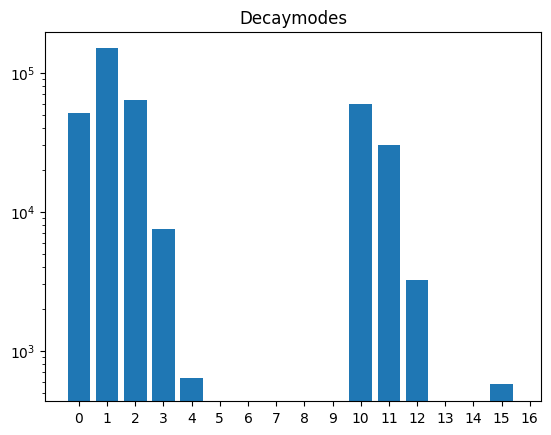

In [12]:
dms = np.arange(17)
plt.title("Decaymodes")
plt.hist(
    z_data["gen_jet_tau_decaymode"], bins=dms,
    width=0.8
)
plt.yscale('log')
plt.xticks(dms+0.4, dms);

## Decay mode remapping